In [1]:
from numba import jit,njit 
import state_utils

state_utils.set_cohort("Poyet")
state_utils.set_host("am")
state_utils.set_midas_db_type("standard")

import matplotlib.pyplot as plt
import cPickle
import pandas as pd
import state_utils
import config
import figure_utils as fu
import numpy
from itertools import cycle
import random as rand

from random import randint,sample
import seaborn as sns

from sklearn import metrics 
from math import log
from parse_midas_data import parse_good_species_list
import sys

good_species = parse_good_species_list()

dates = config.dates
dates_diff = dates.diff()
spec_df = pd.read_csv("%sspecies/relative_abundance.txt.bz2" % config.data_directory,index_col=0,sep="\t")

strain_tot_df = pd.DataFrame(columns=spec_df.columns)

cluster_min_SNV_size = config.cluster_min_SNV_size
strainfinder_dir = config.strainfinder_directory 
dates = config.dates

min_coverage = 5

species = "Bacteroides_vulgatus_57955"
base_dist_path = "/u/scratch/r/rwolff/distance_matrices/%s/%s/%s" % (config.cohort,config.host,species)

sys.stderr.write("Processing %s \n\n" % species)

snp_alignment = pd.read_pickle("%s/%s.strainfinder.p" %  (strainfinder_dir ,species))
samples = pd.read_pickle("%s/%s.strainfinder.samples.p" % (strainfinder_dir ,species))
samples = [s.decode("utf-8") for s in samples]

snp_locations = pd.read_pickle("%s/%s.strainfinder.locations.p" % (strainfinder_dir,species))


Processing Bacteroides_vulgatus_57955 



B ovatus am - standard: 2 strains, isolate 1 strain. Paper: 1 strain, with multiple lineages. 

R bromii am - standard: 1 strain, isolate 2 strains.

In [2]:
good_species

['Bacteroides_vulgatus_57955',
 'Bacteroides_uniformis_57318',
 'Eubacterium_rectale_56927',
 'Bacteroides_ovatus_58035',
 'Bacteroides_xylanisolvens_57185',
 'Bacteroides_stercoris_56735',
 'Parabacteroides_merdae_56972',
 'Ruminococcus_bromii_62047',
 'Ruminococcus_bicirculans_59300',
 'Bacteroides_fragilis_54507',
 'Barnesiella_intestinihominis_62208',
 'Faecalibacterium_prausnitzii_57453',
 'Phascolarctobacterium_sp_59817']

In [3]:
cluster_As = []
cluster_Ds = []
for snp_idx in range(0,snp_alignment.shape[1]):
    Ds = snp_alignment[:,snp_idx,:].sum(axis=1)
    As = snp_alignment[:,snp_idx,0]
    As = numpy.reshape(As, (1,len(As)))
    Ds = numpy.reshape(Ds, (1,len(Ds)))

    cluster_As.append(As[0])
    cluster_Ds.append(Ds[0])

cluster_As = numpy.array(cluster_As)
cluster_Ds = numpy.array(cluster_Ds)

As = pd.DataFrame(cluster_As,columns=samples,index=snp_locations)
Ds = pd.DataFrame(cluster_Ds,columns=samples,index=snp_locations)

samples_sorted=list(dates.loc[samples].sort_values().index)

As = As.loc[:,samples_sorted]
Ds = Ds.loc[:,samples_sorted]

F = As/Ds

Ass = As
Dss = Ds.loc[Ass.index]


$$d(\hat{f}_{it},\hat{f}_{jt}) = \frac{1}{T} \sum_{t=1}^T \frac{2(D_{it} + D_{jt})(\hat{f}_{it} - \hat{f}_{jt})^2}{{(\hat{f}_{it} + \hat{f}_{jt})(1 - \hat{f}_{it} + 1- \hat{f}_{jt})}}$$

In [4]:
@njit
def mat_nmrt(k,fi,F,di,D,N):
    
    O = numpy.zeros(N)
    
    for i in range(N - k - 1):
        
        j = i + k + 1
        
        fj = F[j]
        dj = D[j]
        
        O[j] = numpy.nanmean((di + dj)*((fi - fj)**2)/((fi + fj)*(1 - fi + 1 - fj)))
        
    return(2.0*O)

In [5]:
@njit
def D_mat_fun1(num,F,D,D_mat):   

    for k in xrange(num - 1):
        
        O = numpy.zeros(num)
        
        di = D[k]
        fi = F[k]
        
        for i in xrange(num - k - 1):

            j = i + k + 1

            fj = F[j]
            dj = D[j]

            O[j] = 2*numpy.nanmean((di + dj)*((fi - fj)**2)/((fi + fj)*(1 - fi + 1 - fj)))        
        
        D_mat[k] = O
    
    return D_mat

In [6]:
@njit
def D_mat_fun2(num,F,D,D_mat_in):   

    for k in xrange(num - 1):
        
        O = numpy.zeros(num)       
        di = D[k]
        ## reverse polarization
        fi = 1-F[k]
        
        for i in xrange(num - k - 1):

            j = i + k + 1
            
            fj = F[j]
            dj = D[j]

            O[j] = 2*numpy.nanmean((di + dj)*((fi - fj)**2)/((fi + fj)*(1 - fi + 1 - fj)))        
        
        D_mat_in[k] = O
    
    return D_mat_in

In [7]:
def return_clus(D_mat_close,Fs_sub):
    D_mat_close_sorted_sum = D_mat_close.sum().sort_values()
    desired_idx = D_mat_close_sorted_sum.index[-1]
    clus_idxs = D_mat_close.loc[D_mat_close[desired_idx]].index
    clus = Fs_sub.loc[i_list_idx[clus_idxs]]
    
    return clus,clus_idxs

In [8]:
def drop_clus_idxs(D_mat_close,clus_idxs):
    D_mat_close_out = D_mat_close.drop(clus_idxs).drop(clus_idxs,axis=1)
    return D_mat_close_out

In [9]:
def polarize_clus(clus,clus_idxs,D_mat_1,D_mat_2):
    
    ## polarize whole cluster based on polarization of first cluster element
    clus_to_pol = 1 - clus[D_mat_1[clus_idxs[0],clus_idxs] > D_mat_2[clus_idxs[0],clus_idxs]]
    clus_no_pol = clus[D_mat_1[clus_idxs[0],clus_idxs] < D_mat_2[clus_idxs[0],clus_idxs]]

    clus_pol = pd.concat([clus_to_pol,clus_no_pol],ignore_index=True)
    
    return(clus_pol)

In [10]:
@njit
def symmetrize(D_mat):
    for i in range(D_mat.shape[0]-1):
        for j in range(i,D_mat.shape[0]):
            D_mat[j][i] = D_mat[i][j]
    return(D_mat)

In [12]:
min_coverage = 0
Ass = Ass.mask(Dss < min_coverage)
Ass = Ass.mask(Ass == 0)
Ass = Ass.mask(Ass == Dss)

Fs = Ass/Dss

Fs = Fs.loc[Fs.notna().T.sum() > int(F.shape[1]/2)]

Ass = Ass.loc[Fs.index]
Dss = Dss.loc[Fs.index]

fss = Ass.values/(Dss.values + (Dss.values == 0))

cluster_As = Ass.values
cluster_Ds = Dss.values
cluster_fs = cluster_As/(cluster_Ds + (cluster_Ds == 0))


In [13]:
Dss.iloc[:,0].median()

58.0

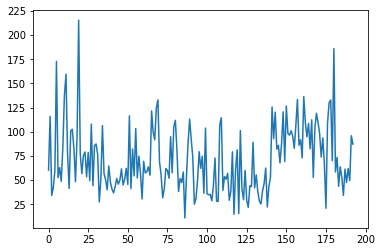

In [14]:
plt.plot(Dss.mean().values)

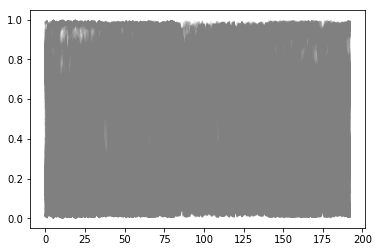

In [15]:
plt.plot(Fs.sample(5000).T.values,color="grey",alpha=.1);

In [34]:
Fs.shape[0]

21858

In [35]:
num = min(25000,Fs.shape[0])
i_list = sample(range(Fs.shape[0]),num)
i_list_idx = Fs.iloc[i_list].index

Ass_sub = Ass.loc[i_list_idx]
Dss_sub = Dss.loc[i_list_idx]
Fs_sub = Fs.loc[i_list_idx]

fss_sub = Ass_sub.values/(Dss_sub.values + (Dss_sub.values == 0))

cluster_As_sub = Ass_sub.values
cluster_Ds_sub = Dss_sub.values
cluster_fs_sub = cluster_As_sub/(cluster_Ds_sub + (cluster_Ds_sub == 0))


In [ ]:
D_mat = numpy.zeros([num,num])
%time D_mat_1 = D_mat_fun1(num,fss_sub,cluster_Ds_sub,D_mat)
D_mat = numpy.zeros([num,num]) 
%time D_mat_2 = D_mat_fun2(num,fss_sub,cluster_Ds_sub,D_mat)

In [ ]:
D_mat = numpy.fmin(D_mat_1,D_mat_2)
#D_mat = D_mat + D_mat.T

In [ ]:
D_mat = symmetrize(D_mat)

In [ ]:
D_mat_close = pd.DataFrame(D_mat < 3.5) 

In [ ]:
clus1,clus_idxs_1 = return_clus(D_mat_close,Fs_sub)
clus1_pol = polarize_clus(clus1,clus_idxs_1,D_mat_1,D_mat_2)
D_mat_close_1 = drop_clus_idxs(D_mat_close,clus_idxs_1)

clus2,clus_idxs_2 = return_clus(D_mat_close_1,Fs_sub)
clus2_pol = polarize_clus(clus2,clus_idxs_2,D_mat_1,D_mat_2)
D_mat_close_2 = drop_clus_idxs(D_mat_close_1,clus_idxs_2)

clus3,clus_idxs_3 = return_clus(D_mat_close_2,Fs_sub)
clus3_pol = polarize_clus(clus3,clus_idxs_3,D_mat_1,D_mat_2)
D_mat_close_3 = drop_clus_idxs(D_mat_close_2,clus_idxs_3)

clus4,clus_idxs_4= return_clus(D_mat_close_3,Fs_sub)
clus4_pol = polarize_clus(clus4,clus_idxs_4,D_mat_1,D_mat_2)
D_mat_close_4 = drop_clus_idxs(D_mat_close_3,clus_idxs_4)

clus5,clus_idxs_5 = return_clus(D_mat_close_4,Fs_sub)
clus5_pol = polarize_clus(clus5,clus_idxs_5,D_mat_1,D_mat_2)
D_mat_close_5 = drop_clus_idxs(D_mat_close_4,clus_idxs_5)

clus6,clus_idxs_6= return_clus(D_mat_close_5,Fs_sub)
clus6_pol = polarize_clus(clus6,clus_idxs_6,D_mat_1,D_mat_2)
D_mat_close_6 = drop_clus_idxs(D_mat_close_2,clus_idxs_6)

In [ ]:
(clus1_pol.shape,clus2_pol.shape,clus3_pol.shape,clus4_pol.shape,clus5_pol.shape,clus6_pol.shape)

In [ ]:
plt.plot(clus1_pol.T.values,color="grey",alpha=.002);
plt.plot(clus1_pol.median().values)
plt.ylim([0,1])

In [ ]:
plt.plot(clus2_pol.T.values,color="grey",alpha=.002);
plt.plot(clus2_pol.median().values)
plt.ylim([0,1])

In [ ]:
plt.plot(clus2_pol.median().values + (clus1_pol.median().values) + (1-clus3_pol.median().values))
plt.ylim([0,2])

(0, 1)

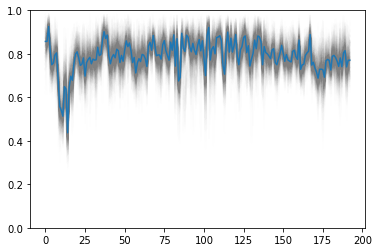

In [29]:
plt.plot(clus3_pol.T.values,color="grey",alpha=.007);
plt.plot(clus3_pol.median().values)
plt.ylim([0,1])

In [ ]:
plt.plot(clus4_pol.T.values,color="grey",alpha=.02);
plt.plot(clus4_pol.median().values)
plt.ylim([0,1])

In [ ]:
plt.plot(clus5_pol.T.values,color="grey",alpha=.02);
plt.plot(clus1_pol.median().values)
plt.ylim([0,1])

In [ ]:
plt.plot(clus6_pol.T.values,color="grey",alpha=.02);
#plt.plot(clus1_pol.median().values)
plt.ylim([0,1])

In [ ]:
clus1_pol.shape

In [ ]:
clus3_pol.shape

In [ ]:
clus4,clus_idxs_4 = return_clus(D_mat_close_3,Fs_sub)
clus4_pol = polarize_clus(clus4,clus_idxs_4,D_mat_1,D_mat_2)
D_mat_close_4 = drop_clus_idxs(D_mat_close_3,clus_idxs_4)


In [ ]:
clus4.shape

In [ ]:
plt.plot(clus2_pol.sample(1000).T.values,color="grey",alpha=.002);
plt.plot(clus2_pol.median().values)
plt.ylim([0,1])

In [ ]:
clus3.shape

In [ ]:
plt.plot(clus3.sample(1000).T.values,color="grey",alpha=.002);
plt.plot(clus3.median().values)
plt.ylim([0,1])

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot((1-clus1.median().values) + (clus2.median().values))
#ax.plot()
#ax.plot(clus3.median().values)

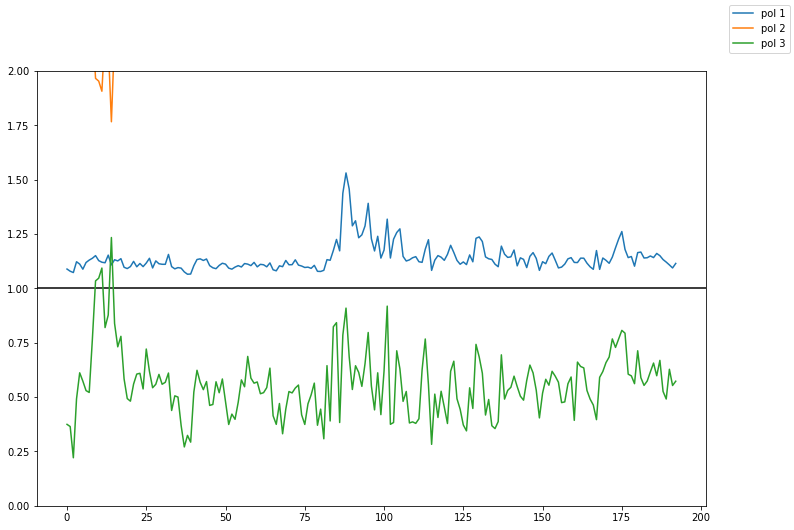

In [26]:
fig,ax = plt.subplots(figsize=(12,8))
ax.axhline(1,color="k")

#ax.plot((1-clus1.median().values) + clus2.median().values,label="pol 1")
#ax.plot(clus1.median().values + (1-clus2.median().values),label="pol 2")

ax.plot((1-clus1_pol.median().values) + clus2_pol.median().values + clus3_pol.median().values,label="pol 1")
ax.plot(clus1_pol.median().values + (1-clus2_pol.median().values) + clus3_pol.median().values,label="pol 2")
ax.plot((1-clus1_pol.median().values) + (clus2_pol.median().values) + (1-clus3_pol.median().values),label="pol 3")

ax.set_ylim([0,2])
fig.legend()


In [ ]:
fig,ax = plt.subplots(figsize=(12,8))

ax.plot(clus1_pol.T.values,color="grey",alpha=.02)
ax.plot(clus1_pol.median().values,lw=1,zorder=10,color="yellow");

ax.plot(clus2_pol.T.values,color="grey",alpha=.02);
ax.plot(clus2_pol.median().values,lw=1,zorder=10,color="orange");

#ax.plot(clus3_pol.T.values,color="grey",alpha=.02);
#ax.plot(clus3_pol.median().values,lw=1,zorder=10,color="green");

#ax.plot(clus5.sample(clus5.shape[0]).T.values,color="red",alpha=.002);
#ax.plot(clus5.median().values,lw=1,zorder=10,color="green");

In [ ]:
plt.plot(clus1_pol.median() + clus2_pol.median())